# Stock NeurIPS2018 Part 2. Train
This series is a reproduction of *the process in the paper Practical Deep Reinforcement Learning Approach for Stock Trading*. 

This is the second part of the NeurIPS2018 series, introducing how to use FinRL to make data into the gym form environment, and train DRL agents on it.

Other demos can be found at the repo of [FinRL-Tutorials]((https://github.com/AI4Finance-Foundation/FinRL-Tutorials)).

# Part 1. Install Packages

In [1]:
import pandas as pd
from stable_baselines3.common.logger import configure

import numpy as np
import datetime
import yfinance as yf

from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl import config_tickers
from finrl.config import INDICATORS

import itertools

from finrl.agents.stablebaselines3.models import DRLAgent
from finrl.config import INDICATORS, TRAINED_MODEL_DIR, RESULTS_DIR
from finrl.main import check_and_make_directories
from Envs.env_stocktrading import StockTradingEnv

check_and_make_directories([TRAINED_MODEL_DIR])

# Part 2. Build A Market Environment in OpenAI Gym-style

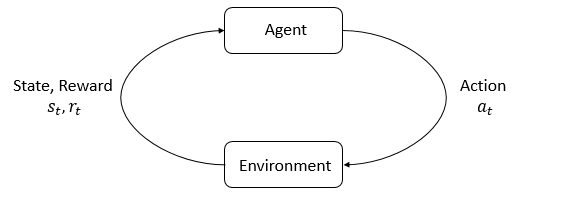

The core element in reinforcement learning are **agent** and **environment**. You can understand RL as the following process: 

The agent is active in a world, which is the environment. It observe its current condition as a **state**, and is allowed to do certain **actions**. After the agent execute an action, it will arrive at a new state. At the same time, the environment will have feedback to the agent called **reward**, a numerical signal that tells how good or bad the new state is. As the figure above, agent and environment will keep doing this interaction.

The goal of agent is to get as much cumulative reward as possible. Reinforcement learning is the method that agent learns to improve its behavior and achieve that goal.

To achieve this in Python, we follow the OpenAI gym style to build the stock data into environment.

state-action-reward are specified as follows:

* **State s**: The state space represents an agent's perception of the market environment. Just like a human trader analyzing various information, here our agent passively observes the price data and technical indicators based on the past data. It will learn by interacting with the market environment (usually by replaying historical data).

* **Action a**: The action space includes allowed actions that an agent can take at each state. For example, a ∈ {−1, 0, 1}, where −1, 0, 1 represent
selling, holding, and buying. When an action operates multiple shares, a ∈{−k, ..., −1, 0, 1, ..., k}, e.g.. "Buy 10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or −10, respectively

* **Reward function r(s, a, s′)**: Reward is an incentive for an agent to learn a better policy. For example, it can be the change of the portfolio value when taking a at state s and arriving at new state s',  i.e., r(s, a, s′) = v′ − v, where v′ and v represent the portfolio values at state s′ and s, respectively


**Market environment**: 30 constituent stocks of Dow Jones Industrial Average (DJIA) index. Accessed at the starting date of the testing period.

## Read data

We first read the .csv file of our training data into dataframe.

In [2]:
train = pd.read_csv('all_data_with_sentiment_FINAL.csv')

# If you are not using the data generated from part 1 of this tutorial, make sure 
# it has the columns and index in the form that could be make into the environment. 
# Then you can comment and skip the following two lines.
#train = train.set_index(train.columns[0])
#train.index.names = ['']

In [3]:
import numpy as np

# Add a new column 'random' with random values between 0 and 1
train['random'] = np.random.rand(len(train))

print(train.head())

                  date   tic     open     high      low    close     volume  \
0  2021-11-24 14:00:00  AAPL  159.380  159.703  158.862  159.085  3513469.0   
1  2021-11-24 14:00:00   PFE   47.758   47.831   47.607   47.735   686904.0   
2  2021-11-24 14:00:00    MO   38.575   38.598   38.350   38.398   295661.0   
3  2021-11-24 14:00:00  META  340.290  341.370  339.000  339.175   695874.0   
4  2021-11-24 14:00:00    PG  141.959  142.221  141.802  142.113   230089.0   

   day  macd     boll_ub  ...  dx_30  close_30_sma  close_60_sma     vix  \
0  5.0   0.0  160.308182  ...  100.0       159.085       159.085  85.622   
1  5.0   0.0  158.835572  ...  100.0        47.735        47.735  85.622   
2  5.0   0.0  160.308182  ...  100.0        38.398        38.398  85.622   
3  5.0   0.0  160.308182  ...  100.0       339.175       339.175  85.622   
4  5.0   0.0  142.570497  ...  100.0       142.113       142.113  85.622   

     change  stocktwitsPosts  stocktwitsLikes  stocktwitsImpressions

In [4]:
SENTIMENT = ['stocktwitsPosts','stocktwitsLikes','stocktwitsImpressions','stocktwitsSentiment', 'random']

In [5]:
# Sort the DataFrame by the 'date' column
train = train.sort_values(by='date')

# Create a mapping of unique dates to their corresponding index
date_mapping = {date: idx for idx, date in enumerate(train['date'].unique())}

# Map the 'date' column to the date_mapping to get the new index
train['index'] = train['date'].map(date_mapping)

# Set the new index for the DataFrame
train.set_index('index', inplace=True, drop=True)
# Specify the path where you want to save the CSV file
output_path = r"C:\Users\potap\FinARL\automatic-stock-trading-applied-reinforcement-learning-sommer-term-2023\Generated Sentiment Data in FinRL\stock_data\all_data_with_index.csv"

# Save the DataFrame to CSV
train.to_csv(output_path, index=False)

print(f"Data saved to {output_path}")
print(train.head())

Data saved to C:\Users\potap\FinARL\automatic-stock-trading-applied-reinforcement-learning-sommer-term-2023\Generated Sentiment Data in FinRL\stock_data\all_data_with_index.csv
                      date   tic     open     high      low    close  \
index                                                                  
0      2021-11-24 14:00:00  AAPL  159.380  159.703  158.862  159.085   
0      2021-11-24 14:00:00   NKE  168.081  168.315  167.650  168.123   
0      2021-11-24 14:00:00   PEP  154.583  154.732  154.265  154.514   
0      2021-11-24 14:00:00  NVDA  323.761  325.132  321.596  323.210   
0      2021-11-24 14:00:00  NFLX  659.920  660.880  656.890  657.750   

          volume  day  macd     boll_ub  ...  dx_30  close_30_sma  \
index                                    ...                        
0      3513469.0  5.0   0.0  160.308182  ...  100.0       159.085   
0       164604.0  5.0   0.0  168.815945  ...  100.0       168.123   
0        88332.0  5.0   0.0  158.835572  .

In [6]:
train = train.fillna(0)
train.dtypes

date                      object
tic                       object
open                     float64
high                     float64
low                      float64
close                    float64
volume                   float64
day                      float64
macd                     float64
boll_ub                  float64
boll_lb                  float64
rsi_30                   float64
cci_30                   float64
dx_30                    float64
close_30_sma             float64
close_60_sma             float64
vix                      float64
change                   float64
stocktwitsPosts          float64
stocktwitsLikes          float64
stocktwitsImpressions    float64
stocktwitsSentiment      float64
random                   float64
dtype: object

## Construct the environment

Calculate and specify the parameters we need for constructing the environment.

In [7]:
#SENTIMENT = ['stocktwitsPosts','stocktwitsLikes','stocktwitsImpressions','stocktwitsSentiment']

In [8]:
#SENTIMENT = []

In [9]:
INDICATORS.append('vix')

In [10]:
stock_dimension = len(train.tic.unique())
state_space = 1 + 4*stock_dimension + len(INDICATORS)*stock_dimension +  len(SENTIMENT)*stock_dimension
#state_space = 379
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 30, State Space: 541


In [11]:
SENTIMENT

['stocktwitsPosts',
 'stocktwitsLikes',
 'stocktwitsImpressions',
 'stocktwitsSentiment',
 'random']

In [12]:
INDICATORS

['macd',
 'boll_ub',
 'boll_lb',
 'rsi_30',
 'cci_30',
 'dx_30',
 'close_30_sma',
 'close_60_sma',
 'vix']

In [13]:
buy_cost_list = sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension

env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "sentiment_list" : SENTIMENT,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4
}


e_train_gym = StockTradingEnv(df = train, **env_kwargs)

## Environment for training

In [14]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


# Part 3: Train DRL Agents
* Here, the DRL algorithms are from **[Stable Baselines 3](https://stable-baselines3.readthedocs.io/en/master/)**. It's a library that implemented popular DRL algorithms using pytorch, succeeding to its old version: Stable Baselines.
* Users are also encouraged to try **[ElegantRL](https://github.com/AI4Finance-Foundation/ElegantRL)** and **[Ray RLlib](https://github.com/ray-project/ray)**.

In [15]:
agent = DRLAgent(env = env_train)

# Set the corresponding values to 'True' for the algorithms that you want to use
if_using_a2c = True
if_using_ddpg = True
if_using_ppo = True
if_using_td3 = True
if_using_sac = True

## Agent Training: 5 algorithms (A2C, DDPG, PPO, TD3, SAC)


### Agent 1: A2C


In [16]:
agent = DRLAgent(env = env_train)
model_a2c = agent.get_model("a2c")

if if_using_a2c:
  # set up logger
  tmp_path = RESULTS_DIR + '/a2c'
  new_logger_a2c = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_a2c.set_logger(new_logger_a2c)

{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007}
Using cpu device
Logging to results/a2c


In [17]:
trained_a2c = agent.train_model(model=model_a2c, 
                             tb_log_name='a2c',
                             total_timesteps=500000) if if_using_a2c else None

-------------------------------------
| time/                 |           |
|    fps                | 188       |
|    iterations         | 100       |
|    time_elapsed       | 2         |
|    total_timesteps    | 500       |
| train/                |           |
|    entropy_loss       | -42.5     |
|    explained_variance | 0.0051    |
|    learning_rate      | 0.0007    |
|    n_updates          | 99        |
|    policy_loss        | -3.61e+03 |
|    reward             | 27.20757  |
|    std                | 0.997     |
|    value_loss         | 1.24e+04  |
-------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 189        |
|    iterations         | 200        |
|    time_elapsed       | 5          |
|    total_timesteps    | 1000       |
| train/                |            |
|    entropy_loss       | -42.5      |
|    explained_variance | 0.00398    |
|    learning_rate      | 0.0007     |
| 

In [18]:
trained_a2c.save(TRAINED_MODEL_DIR + "/agent_a2c") if if_using_a2c else None

### Agent 2: DDPG

In [9]:
agent = DRLAgent(env = env_train)
model_ddpg = agent.get_model("ddpg")

if if_using_ddpg:
  # set up logger
  tmp_path = RESULTS_DIR + '/ddpg'
  new_logger_ddpg = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_ddpg.set_logger(new_logger_ddpg)

{'batch_size': 128, 'buffer_size': 50000, 'learning_rate': 0.001}
Using cpu device
Logging to results/ddpg


In [11]:
trained_ddpg = agent.train_model(model=model_ddpg, 
                             tb_log_name='ddpg',
                             total_timesteps=50) if if_using_ddpg else None

In [ ]:
trained_ddpg.save(TRAINED_MODEL_DIR + "/agent_ddpg") if if_using_ddpg else None

### Agent 3: PPO

In [12]:
agent = DRLAgent(env = env_train)
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.01,
    "learning_rate": 0.00025,
    "batch_size": 128,
}
model_ppo = agent.get_model("ppo",model_kwargs = PPO_PARAMS)

if if_using_ppo:
  # set up logger
  tmp_path = RESULTS_DIR + '/ppo'
  new_logger_ppo = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_ppo.set_logger(new_logger_ppo)

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 128}
Using cpu device
Logging to results/ppo


In [ ]:
trained_ppo = agent.train_model(model=model_ppo, 
                             tb_log_name='ppo',
                             total_timesteps=200000) if if_using_ppo else None

In [14]:
trained_ppo.save(TRAINED_MODEL_DIR + "/agent_ppo") if if_using_ppo else None

### Agent 4: TD3

In [19]:
agent = DRLAgent(env = env_train)
TD3_PARAMS = {"batch_size": 100, 
              "buffer_size": 1000000, 
              "learning_rate": 0.001}

model_td3 = agent.get_model("td3",model_kwargs = TD3_PARAMS)

if if_using_td3:
  # set up logger
  tmp_path = RESULTS_DIR + '/td3'
  new_logger_td3 = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_td3.set_logger(new_logger_td3)

{'batch_size': 100, 'buffer_size': 1000000, 'learning_rate': 0.001}
Using cpu device
Logging to results/td3


/Users/lolo/Desktop/stock/lib/python3.10/site-packages/stable_baselines3/common/buffers.py:229: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 4.46GB > 3.08GB
  warnings.warn(


In [20]:
trained_td3 = agent.train_model(model=model_td3, 
                             tb_log_name='td3',
                             total_timesteps=500000) if if_using_td3 else None

----------------------------------
| time/              |           |
|    episodes        | 4         |
|    fps             | 114       |
|    time_elapsed    | 108       |
|    total_timesteps | 12412     |
| train/             |           |
|    actor_loss      | 3.08e+04  |
|    critic_loss     | 5.72e+06  |
|    learning_rate   | 0.001     |
|    n_updates       | 9309      |
|    reward          | 18.409077 |
----------------------------------
day: 3102, episode: 170
begin_total_asset: 1000000.00
end_total_asset: 1019754.19
total_reward: 19754.19
total_cost: 1150.29
total_trades: 58900
Sharpe: 1.186
----------------------------------
| time/              |           |
|    episodes        | 8         |
|    fps             | 112       |
|    time_elapsed    | 221       |
|    total_timesteps | 24824     |
| train/             |           |
|    actor_loss      | 2.24e+04  |
|    critic_loss     | 1.47e+06  |
|    learning_rate   | 0.001     |
|    n_updates       | 21721     |
|

In [21]:
trained_td3.save(TRAINED_MODEL_DIR + "/agent_td3") if if_using_td3 else None

### Agent 5: SAC

In [ ]:
agent = DRLAgent(env = env_train)
SAC_PARAMS = {
    "batch_size": 128,
    "buffer_size": 100000,
    "learning_rate": 0.0001,
    "learning_starts": 100,
    "ent_coef": "auto_0.1",
}

model_sac = agent.get_model("sac",model_kwargs = SAC_PARAMS)

if if_using_sac:
  # set up logger
  tmp_path = RESULTS_DIR + '/sac'
  new_logger_sac = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_sac.set_logger(new_logger_sac)

In [ ]:
trained_sac = agent.train_model(model=model_sac, 
                             tb_log_name='sac',
                             total_timesteps=70000) if if_using_sac else None

In [ ]:
trained_sac.save(TRAINED_MODEL_DIR + "/agent_sac") if if_using_sac else None

## Save the trained agent
Trained agents should have already been saved in the "trained_models" drectory after you run the code blocks above.

For Colab users, the zip files should be at "./trained_models" or "/content/trained_models".

For users running on your local environment, the zip files should be at "./trained_models".